In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

%matplotlib inline

In [2]:
%%time
df = pd.read_csv(
            'final_STC_dataset.csv',
            parse_dates=['date_'],
            dtype={ 
                'user_id_maped': np.uint16, # Unsigned integer (0 to 65535)
                'program_id': str,
                'program_name': str,
                'duration_seconds': np.uint32, # Unsigned integer (0 to 4294967295)
                'program_class': 'category',
                'season': np.uint8, # Unsigned integer (0 to 255)
                'episode': np.uint16, # Unsigned integer (0 to 65535)
                'program_desc': str,
                'program_genre': 'category',
                'hd': bool, 
                'original_name': str,
                'series_title': bool,
                'runtime': np.float32,
                'vote_average': np.float32,
                'user_rating': np.float32,
                'age_group': 'category',
                'content_rating': 'category'
            })


df.head()

CPU times: user 12.5 s, sys: 1.07 s, total: 13.6 s
Wall time: 11.8 s


,date_,user_id_maped,program_id,program_name,original_name,program_class,season,episode,program_desc,program_genre,series_title,hd,title,duration_minutes,total_runtime,user_rating,avg_rating,content_rating,age_group
0,2017-08-16,6928,M0009670,The Boss Baby,The Boss Baby,MOVIE,0,0,Animation MovieThe Boss Baby (HD),Animation,False,True,The Boss Baby,0.28,96.94,1.5,6.1,TV-Y,2-6
1,2017-05-27,26138,M0005792SD,100 Streets,100 Streets,MOVIE,0,0,Drama Movie100 Streets,Drama,False,False,100 Streets,0.67,92.94,1.5,6.2,TV-14,+14
2,2017-09-16,19082,S000805901001,Heroes Reborn Brave New World,Heroes Reborn,SERIES/EPISODES,1,1,Drama MovieBrave New World (HD),Drama,False,False,Heroes Reborn,28.20,60.00,4.7,6.7,TV-14,+14
3,2017-05-21,7946,M0004410,Moana,Moana,MOVIE,0,0,Animation MovieMoana (HD),Animation,False,True,Moana,0.28,107.06,1.5,7.3,PG,+8
4,2017-08-10,7418,M0005895,The Mermaid Princess,The Mermaid Princess,MOVIE,0,0,Animation MovieThe Mermaid Princess (HD),Animation,False,True,The Mermaid Princess,0.13,77.00,1.5,4.4,PG,+8


In [5]:
df.original_name=df.original_name.apply(lambda x: x.replace('(HD)',''))
df.original_name=df.original_name.apply(lambda x: x.replace('(T)',''))
new = df["original_name"].str.split(",", n = 1, expand = True) 
df["original_name"]= new[0]    
df['original_name']=df['original_name'].str.replace(r', Season* \d*|, Episode* \d*|, S*\d*', ' ')
df.original_name = df.original_name.str.strip()


df.program_name=df.program_name.apply(lambda x: x.replace('(HD)',''))
df.program_name=df.program_name.apply(lambda x: x.replace('(T)',''))
new = df["program_name"].str.split(",", n = 1, expand = True) 
df["program_name"]= new[0] 
df['program_name']=df['program_name'].str.replace(r', Season* \d*|, Episode* \d*|, S*\d*', ' ')
df.program_name = df.program_name.str.strip()

#df['original_name'] = df['original_name'].str.split().apply(lambda x: [el.capitalize() for el in x]).str.join(' ')

### Popularity and vote average

In [52]:
prog_df = pd.DataFrame(df['original_name'].value_counts()).reset_index()
prog_df.columns = ['original_name', 'popularity']
prog_df.head()

,original_name,popularity
0,Friends,120694
1,Paw Patrol,114519
2,Pingu,86443
3,The Boss Baby,80819
4,Blaze And The Monster Machines,72495


In [53]:
prog_df.count()

original_name    2021
popularity       2021
dtype: int64

In [54]:
temp = df[['original_name', 'avg_rating', ]]
temp.drop_duplicates(subset ='original_name', keep = 'first', inplace = True) 
prog_df = pd.merge(prog_df, temp, how='left', on='original_name')


/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
prog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2021 entries, 0 to 2020
Data columns (total 3 columns):
original_name    2021 non-null object
popularity       2021 non-null int64
avg_rating       2021 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 63.2+ KB


In [56]:
prog_df['popularity'].describe()

count      2021.000000
mean       1942.688768
std        7043.013843
min           1.000000
25%         106.000000
50%         338.000000
75%        1171.000000
max      120694.000000
Name: popularity, dtype: float64

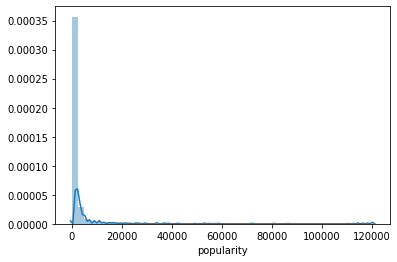

In [57]:
sns.distplot(prog_df['popularity'].fillna(prog_df['popularity'].median()))
plt.show()

In [58]:
prog_df['avg_rating'].describe()

count    2021.000000
mean        5.826069
std         1.559510
min         1.500000
25%         5.300000
50%         6.100000
75%         6.800000
max         9.870000
Name: avg_rating, dtype: float64

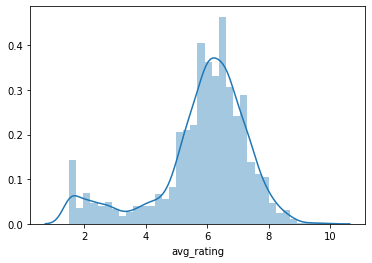

In [59]:
sns.distplot(prog_df['avg_rating']);

### run_time

In [60]:
dfAggregated=df.groupby(
   ['original_name', 'user_id_maped', 'total_runtime'], as_index=False
).agg(
    {
        'duration_minutes': [max,sum,'count']
            
    }
)

dfAggregated.columns=['program','userID', 'program_runtime','duration','total_watch','popularity']

dfAggregated.sort_values('program_runtime', ascending=False)#.head(250)

,program,userID,program_runtime,duration,total_watch,popularity
573832,Life,32013,499.80,1.38,1.38,1
572987,Life,5746,499.80,0.57,0.57,1
573447,Life,19759,499.80,0.25,0.25,1
573887,Life,34228,499.80,1.38,1.38,1
573100,Life,9158,499.80,1.37,1.37,1
...,...,...,...,...,...,...
822318,Sehhee Wa Saree,4662,0.10,0.10,0.10,1
1207295,Zay Al Ward - Ep 12,19878,0.10,0.10,0.10,1
1133214,Trouble With The Curve,33076,0.10,0.10,0.10,1
70771,Allo Marhaba,22883,0.08,0.08,0.08,1


## Popularity based system

In [61]:
popularity = prog_df[prog_df['popularity'].notnull()]['popularity'].astype('uint32')

vote_averages = prog_df[prog_df['avg_rating'].notnull()]['avg_rating'].astype('float32')

C = vote_averages.mean()
C

5.826065540313721

In [62]:
vote_count = prog_df[prog_df['popularity'].notnull()]['popularity'].astype('uint32')
m = vote_count.quantile(0.95)
m

6999.0

In [63]:
def weighted_rating(x):
    v = x['popularity']
    R = x['avg_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [64]:
prog_df['wr'] = prog_df.apply(weighted_rating, axis=1)

In [65]:
prog_df = prog_df.sort_values('wr', ascending=False)
prog_df

,original_name,popularity,avg_rating,wr
48,Dexter,16389,8.800,7.910032
9,Spongebob Squarepants,53104,8.100,7.835200
14,Yo Gabba Gabba!,38520,8.200,7.834984
21,Jelly Jamm,33686,8.230,7.816454
4,Blaze And The Monster Machines,72495,7.990,7.799478
...,...,...,...,...
83,Dragon Ball Z: Resurrection F,9137,2.518,3.952875
12,Adventures Of Petey And Friends,42563,3.000,3.399089
79,Captain Underpants: The First Epic Movie,9936,1.531,3.306091
73,Tad The Lost Explorer 2,10662,1.511,3.221047


### Content Based Recommender

In [20]:
#pip install surprise

In [69]:
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD

In [68]:
help_df = pd.read_csv('ResultNouser.csv')

help_df.original_name=help_df.original_name.apply(lambda x: x.replace('(HD)',''))
help_df.original_name=help_df.original_name.apply(lambda x: x.replace('(T)',''))
new = help_df["original_name"].str.split(",", n = 1, expand = True) 
help_df["original_name"]= new[0]    
help_df['original_name']=help_df['original_name'].str.replace(r', Season* \d*|, Episode* \d*|, S*\d*', ' ')
help_df['original_name'] = help_df['original_name'].str.split().apply(lambda x: [el.capitalize() for el in x]).str.join(' ')
help_df.original_name = help_df.original_name.str.strip()

help_df.drop_duplicates(subset ='original_name', keep = 'first', inplace = True) 


help_df = pd.merge(help_df[['original_name']], prog_df, how='left', on='original_name')
help_df = help_df.dropna()


,original_name,popularity,avg_rating,wr
0,Spongebob Squarepants,53104.0,8.1,7.835200
1,Black Sails,8921.0,8.2,7.156334
2,My Little Pony: Friendship Is Magic,58810.0,7.6,7.411336
3,Ice Age: Dawn Of The Dinosaurs,498.0,6.5,5.870833
4,Gangsters: America's Most Evil,246.0,7.6,5.886299


In [71]:
temp = df[['original_name', 'program_name', 'program_genre', 'content_rating','program_class']]
temp.drop_duplicates(subset ='original_name', keep = 'first', inplace = True) 
content_based_df = pd.merge(help_df, temp, how='left', on='original_name')

/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [72]:
content_based_df['original_name'] = content_based_df['original_name'].str.strip()
content_based_df['program_genre'] = content_based_df['program_genre'].str.strip()
content_based_df['content_rating'] = content_based_df['content_rating'].str.strip()
content_based_df['program_name'] = content_based_df['program_name'].str.strip()
content_based_df['program_class'] = content_based_df['program_class'].str.strip()



content_based_df['content'] = content_based_df['program_name'] + ' ' + content_based_df['content_rating']
content_based_df['content'] = content_based_df['content'] + ' ' + content_based_df['program_genre']

In [73]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1,2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(content_based_df['content'])

In [74]:
tfidf_matrix.shape

(184, 830)

In [75]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

array([1.        , 0.0153592 , 0.05182204, 0.01463921, 0.01055162,
       0.        , 0.        , 0.02792558, 0.05601109, 0.01035939,
       0.01686639, 0.01235944, 0.01551027, 0.05212342, 0.        ,
       0.        , 0.02457144, 0.01439052, 0.01790064, 0.02619535,
       0.        , 0.01362764, 0.        , 0.02619535, 0.01775614,
       0.02353812, 0.11179193, 0.01767149, 0.01958046, 0.05626301,
       0.        , 0.02845785, 0.06225798, 0.01303414, 0.        ,
       0.0204732 , 0.        , 0.01870613, 0.05563763, 0.        ,
       0.0148751 , 0.01670322, 0.01508578, 0.        , 0.01502632,
       0.        , 0.        , 0.02353812, 0.08428291, 0.01551027,
       0.02619535, 0.01360454, 0.02619535, 0.01958046, 0.02695847,
       0.07765652, 0.01667459, 0.06174631, 0.05690996, 0.01306415,
       0.01370489, 0.01689602, 0.        , 0.        , 0.02845785,
       0.02845785, 0.01384635, 0.        , 0.0204732 , 0.        ,
       0.        , 0.        , 0.01594372, 0.        , 0.     

In [76]:
titles = content_based_df['original_name'].str.strip()

In [77]:
def get_recommendations(title):
    idx = titles[titles.str.contains(title)].index[0]
   # idx = titles[titles==title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [78]:
get_recommendations('Spongebob Squarepants')

119        The Spongebob Squarepants Movie
161                                     Up
105                                  Shrek
26                                  Frozen
159                            Teletubbies
177                                Caillou
48                           Oscar's Oasis
81                    Hotel Transylvania 2
127                         Wreck-it Ralph
55                           Kung Fu Panda
32                          Bubble Guppies
57                       Shimmer And Shine
58          Blaze And The Monster Machines
29            Teenage Mutant Ninja Turtles
8                               Paw Patrol
38                       Littlest Pet Shop
13         Dora And Friends: Into The City
2      My Little Pony: Friendship Is Magic
82                       Dora The Explorer
31                                    Cars
64                             Ratatouille
65                                   Mulan
101                              Anastasia
162        

In [79]:
def improved_recommendations(title):
    idx = titles[titles.str.contains(title)].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]

    
    movies = prog_df.iloc[movie_indices][['original_name', 'popularity', 'avg_rating']]
    vote_counts = movies[movies['popularity'].notnull()]['popularity'].astype('float')
    vote_averages = movies[movies['avg_rating'].notnull()]['avg_rating'].astype('float')
    C = vote_averages.mean()
    # popular moview > 60%
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['popularity'] >= m) & (movies['popularity'].notnull()) & (movies['avg_rating'].notnull())]
    qualified['popularity'] = qualified['popularity'].astype('float')
    qualified['avg_rating'] = qualified['avg_rating'].astype('float')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(15)
    return qualified

In [80]:
improved_recommendations('Power')

/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

,original_name,popularity,avg_rating,wr
9,Spongebob Squarepants,53104.0,8.100,7.835200
8,Marcus Level,54803.0,7.742,7.525023
6,My Little Pony: Friendship Is Magic,58810.0,7.600,7.411336
85,Black Sails,8921.0,8.200,7.156334
78,Jane The Virgin,10062.0,7.800,6.990225
1,Paw Patrol,114519.0,7.027,6.957830
45,Kihil Aswad,17228.0,6.746,6.480238
62,Dunkirk,12248.0,6.600,6.318566
100,Hell On Wheels,7105.0,6.746,6.289490
95,War For The Planet Of The Apes,7465.0,6.700,6.277111


### Collaborative Filtering

In [81]:
ratings = dfAggregated
ratings.head(15)

,program,userID,program_runtime,duration,total_watch,popularity
0,#followfriday,119,90.0,0.02,0.02,1
1,#followfriday,131,90.0,1.08,1.46,2
2,#followfriday,192,90.0,0.78,0.78,1
3,#followfriday,204,90.0,1.07,1.07,1
4,#followfriday,235,90.0,1.07,1.15,2
5,#followfriday,333,90.0,1.07,1.07,1
6,#followfriday,424,90.0,1.07,1.07,1
7,#followfriday,434,90.0,0.58,0.58,1
8,#followfriday,506,90.0,1.07,1.07,1
9,#followfriday,507,90.0,1.05,1.28,3


In [82]:
ratings.describe()

,userID,program_runtime,duration,total_watch,popularity
count,1.211155e+06,1.211155e+06,1.211155e+06,1.211155e+06,1.211155e+06
mean,1.769128e+04,1.050842e+02,2.691797e+01,5.230020e+01,3.241678e+00
std,1.000875e+04,9.003299e+01,5.744773e+01,3.051484e+02,2.778183e+01
min,1.000000e+00,3.000000e-02,0.000000e+00,0.000000e+00,1.000000e+00
25%,8.938000e+03,4.156000e+01,8.300000e-01,9.300000e-01,1.000000e+00
50%,1.783000e+04,9.206000e+01,1.950000e+00,3.250000e+00,1.000000e+00
75%,2.638600e+04,1.169400e+02,2.677000e+01,3.472000e+01,2.000000e+00
max,3.428300e+04,4.998000e+02,3.600000e+02,6.161700e+04,7.969000e+03


In [83]:
reader = Reader()

In [84]:
ratings['user_rating'] = (ratings['duration']/ratings['program_runtime']) % 10

In [85]:
data = Dataset.load_from_df(ratings[['program', 'userID', 'user_rating']], reader)

In [86]:
ratings['user_rating'].describe()

count    1.211155e+06
mean     5.152621e-01
std      8.830672e-01
min      0.000000e+00
25%      6.522197e-03
50%      1.929704e-02
75%      1.000000e+00
max      9.992604e+00
Name: user_rating, dtype: float64

In [87]:
from surprise.model_selection import cross_validate
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9698  0.9782  0.9739  0.9687  0.9691  0.9720  0.0036  
MAE (testset)     0.7464  0.7497  0.7466  0.7462  0.7441  0.7466  0.0018  
Fit time          49.72   48.77   44.17   44.05   44.24   46.19   2.51    
Test time         1.33    1.23    2.21    1.87    2.15    1.76    0.41    


{'test_rmse': array([0.96984715, 0.97818364, 0.97388254, 0.96873893, 0.96910775]),
 'test_mae': array([0.74642995, 0.74974026, 0.74656861, 0.74617918, 0.74409708]),
 'fit_time': (49.71688914299011,
  48.76641273498535,
  44.1747510433197,
  44.04947304725647,
  44.236674070358276),
 'test_time': (1.3311681747436523,
  1.228727102279663,
  2.2129440307617188,
  1.873183012008667,
  2.15048885345459)}

In [88]:
trainset = data.build_full_trainset()
svd.fit(trainset)

### Hybrid Recommender

In [89]:
def hybrid(userId, title):
   # idx = Prog_df[Prog_df['program'].str.contains(title)]['index'] 
    idx = titles[titles.str.contains(title)].index[0]
   
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = help_df.iloc[movie_indices][['original_name', 'popularity', 'avg_rating', 'wr']]
    movies['est'] = movies['wr'].apply(lambda x: svd.predict(userId, title).est)
    movies = movies.sort_values(['est'], ascending=False)
    return movies.head(10)

In [90]:
#backup.to_csv("recommended_list.csv")

In [91]:
hybrid(116, 'Power')

,original_name,popularity,avg_rating,wr,est
18,Britannia,1811.0,6.700,6.005713,1
81,Taboo,2110.0,3.348,5.252049,1
155,Halt And Catch Fire,1787.0,5.605,5.781103,1
97,Empire,2330.0,4.000,5.369990,1
24,Quantico,5682.0,6.400,6.083229,1
120,Whiplash,474.0,8.300,5.982983,1
98,Unfriended,3625.0,5.500,5.714809,1
164,Up,81.0,7.800,5.848649,1
9,Painkiller Jane,1538.0,5.200,5.713275,1
135,Swedish D***s,988.0,6.465,5.905102,1


In [92]:
hybrid(11663, 'Wayward Pines')

,original_name,popularity,avg_rating,wr,est
37,Blindspot,18219.0,6.100,6.023972,1
88,Morning Star,4866.0,1.707,4.136780,1
185,The World Wars,930.0,8.100,6.092777,1
51,Shades Of Blue,6137.0,7.010,6.379187,1
21,Friends,120694.0,7.500,7.408250,1
60,Hell On Wheels,7105.0,6.746,6.289490,1
139,Nightcrawler,1070.0,7.600,6.061300,1
130,The Hunted,1318.0,6.000,5.853629,1
86,Pressure,1027.0,5.300,5.758751,1
40,I Killed My Bff,487.0,5.300,5.791842,1


In [93]:
hybrid(16648, 'The Jungle Book')

,original_name,popularity,avg_rating,wr,est
100,Into The Woods,204.0,8.800,5.910292,1
179,Caramel,9149.0,6.800,6.377869,1
97,Empire,2330.0,4.000,5.369990,1
24,Quantico,5682.0,6.400,6.083229,1
81,Taboo,2110.0,3.348,5.252049,1
18,Britannia,1811.0,6.700,6.005713,1
184,Waking Madison,426.0,5.400,5.801621,1
126,Mississippi Grind,1704.0,5.900,5.840542,1
96,Power,7298.0,5.600,5.710669,1
36,Bab Al Hara,14339.0,5.940,5.902629,1


In [94]:
hybrid(25401, 'Maze Runner: The Scorch Trials')

,original_name,popularity,avg_rating,wr,est
176,The Maze Runner,1109.0,7.0,5.986635,1
30,Maze Runner: The Death Cure,1411.0,6.2,5.888803,1
68,Numb,1171.0,5.3,5.750665,1
70,Bean,10494.0,6.3,6.110377,1
144,11.6,1275.0,5.7,5.806639,1
117,Transcendence,852.0,5.9,5.834089,1
106,Everything Will Be Fine,1832.0,6.3,5.924384,1
5,Jumanji: Welcome To The Jungle,2021.0,6.9,6.066689,1
71,The Hunger Games: Mockingjay - Part 1,1214.0,6.6,5.940464,1
63,The Hunger Games: Mockingjay - Part 2,1086.0,6.6,5.930023,1


In [95]:
hybrid(25713, 'Madagascar')

,original_name,popularity,avg_rating,wr,est
61,Madagascar 3: Europe's Most Wanted,1065.0,6.400,5.901864,1
41,Madagascar: Escape 2 Africa,1061.0,6.200,5.875289,1
137,Kung Fu Panda 2,1171.0,6.700,5.951326,1
166,The Adventures Of Tintin,928.0,2.172,5.398290,1
78,The Good Dinosaur,615.0,6.600,5.888578,1
53,The Ant Bully,40.0,5.500,5.824213,1
28,Puss In Boots,1302.0,6.000,5.853347,1
127,Brave,68.0,6.700,5.834475,1
124,Coco,10875.0,4.400,4.958411,1
112,Cinderella,1649.0,5.300,5.725755,1


In [96]:
hybrid(26782, 'Atlanta')

,original_name,popularity,avg_rating,wr,est
180,Smilf,1246.0,6.700,5.958136,1
135,Swedish D***s,988.0,6.465,5.905102,1
134,Jane The Virgin,10062.0,7.800,6.990225,1
164,Up,81.0,7.800,5.848649,1
70,Bean,10494.0,6.300,6.110377,1
111,Friends With Benefits,2333.0,6.500,5.994549,1
9,Painkiller Jane,1538.0,5.200,5.713275,1
158,Zombieland,3351.0,7.200,6.270902,1
146,All Is Bright,967.0,7.500,6.029266,1
11,The White Queen,1804.0,7.800,6.230584,1


In [97]:
hybrid(27085, 'Teen Wolf')

,original_name,popularity,avg_rating,wr,est
37,Blindspot,18219.0,6.100,6.023972,1
88,Morning Star,4866.0,1.707,4.136780,1
149,The Making Of The Mob: Chicago,818.0,6.203,5.865509,1
59,The Shannara Chronicles,4207.0,7.200,6.341873,1
177,Wayward Pines,2693.0,7.400,6.263396,1
185,The World Wars,930.0,8.100,6.092777,1
51,Shades Of Blue,6137.0,7.010,6.379187,1
21,Friends,120694.0,7.500,7.408250,1
60,Hell On Wheels,7105.0,6.746,6.289490,1
40,I Killed My Bff,487.0,5.300,5.791842,1


In [98]:
hybrid(30336, 'Dora And Friends: Into The City')

,original_name,popularity,avg_rating,wr,est
164,Up,81.0,7.800,5.848649,1
84,Dora The Explorer,52701.0,4.992,5.089783,1
0,Spongebob Squarepants,53104.0,8.100,7.835200,1
38,Littlest Pet Shop,57696.0,6.000,5.981183,1
29,Teenage Mutant Ninja Turtles,34041.0,5.800,5.804445,1
58,Blaze And The Monster Machines,72495.0,7.990,7.799478,1
57,Shimmer And Shine,36715.0,7.637,7.347053,1
32,Bubble Guppies,11484.0,6.906,6.497059,1
55,Kung Fu Panda,1875.0,6.900,6.052979,1
21,Friends,120694.0,7.500,7.408250,1


In [99]:
hybrid(32108, 'Bubble Guppies')

,original_name,popularity,avg_rating,wr,est
164,Up,81.0,7.800,5.848649,1
39,The Ring,80.0,4.000,5.805429,1
84,Dora The Explorer,52701.0,4.992,5.089783,1
2,My Little Pony: Friendship Is Magic,58810.0,7.600,7.411336,1
0,Spongebob Squarepants,53104.0,8.100,7.835200,1
13,Dora And Friends: Into The City,26044.0,8.086,7.607312,1
38,Littlest Pet Shop,57696.0,6.000,5.981183,1
8,Paw Patrol,114519.0,7.027,6.957830,1
29,Teenage Mutant Ninja Turtles,34041.0,5.800,5.804445,1
58,Blaze And The Monster Machines,72495.0,7.990,7.799478,1


In [100]:
hybrid(32241, 'The White Queen')

,original_name,popularity,avg_rating,wr,est
96,Power,7298.0,5.600,5.710669,1
18,Britannia,1811.0,6.700,6.005713,1
97,Empire,2330.0,4.000,5.369990,1
24,Quantico,5682.0,6.400,6.083229,1
120,Whiplash,474.0,8.300,5.982983,1
98,Unfriended,3625.0,5.500,5.714809,1
164,Up,81.0,7.800,5.848649,1
9,Painkiller Jane,1538.0,5.200,5.713275,1
135,Swedish D***s,988.0,6.465,5.905102,1
180,Smilf,1246.0,6.700,5.958136,1


In [101]:
# add all users and movie , her only 4 are entered
input= {'userId':[30336, 16648, 25401,25713, 11663, 27085, 116, 32241, 26782, 32108], 'Program': ['Dora And Friends: Into The City',
            'The Jungle Book','Maze Runner: The Scorch Trials','Madagascar',
            'Wayward Pines', 'Teen Wolf', 'Power', 'The White Queen', 'Atlanta', 'Bubble Guppies']}
df_marks = pd.DataFrame(input)
df_marks.iloc[1,0]

ouputFile_ALL=pd.DataFrame()
for i in range (len(df_marks)):
    ouputFile= hybrid(df_marks.iloc[i,0], df_marks.iloc[i,1])
    ouputFile.insert(0,"UserId",df_marks.iloc[i,0],True)
    i=i+1
   
    ouputFile_ALL=pd.concat([ouputFile_ALL, ouputFile.iloc[:,[0,1]]], ignore_index=True)
ouputFile_ALL

,UserId,original_name
0,30336,Up
1,30336,Dora The Explorer
2,30336,Spongebob Squarepants
3,30336,Littlest Pet Shop
4,30336,Teenage Mutant Ninja Turtles
...,...,...
95,32108,Dora And Friends: Into The City
96,32108,Littlest Pet Shop
97,32108,Paw Patrol
98,32108,Teenage Mutant Ninja Turtles


In [102]:
ouputFile_ALL.to_csv("ouputFile_ALL.csv")